# 获取数据

In [20]:
import  configparser
config = configparser.ConfigParser()
config.read('../config.ini')
token = config.get('tushare', 'token')

import tushare as ts
ts.set_token(token)

In [21]:
origin_daily_300 = ts.pro_bar(ts_code='000300.SH', asset='I').sort_values('trade_date').reset_index()
daily_300 = origin_daily_300.copy()
daily_300

,index,ts_code,trade_date,close,open,high,low,pre_close,change,pct_chg,vol,amount
0,4145,000300.SH,20050104,982.7940,994.7690,994.7690,980.6580,1000.0000,-17.2060,-1.7206,7.412869e+06,4.431977e+06
1,4144,000300.SH,20050105,992.5640,981.5770,997.3230,979.8770,982.7940,9.7700,0.9941,7.119109e+06,4.529208e+06
2,4143,000300.SH,20050106,983.1740,993.3310,993.7880,980.3300,992.5640,-9.3900,-0.9460,6.288029e+06,3.921015e+06
3,4142,000300.SH,20050107,983.9580,983.0450,995.7110,979.8120,983.1740,0.7840,0.0797,7.298694e+06,4.737469e+06
4,4141,000300.SH,20050110,993.8790,983.7600,993.9590,979.7890,983.9580,9.9210,1.0083,5.791698e+06,3.762933e+06
...,...,...,...,...,...,...,...,...,...,...,...,...
4141,4,000300.SH,20220117,4767.2762,4728.7595,4775.2385,4726.7083,4726.7317,40.5445,0.8578,1.152957e+08,2.637882e+08
4142,3,000300.SH,20220118,4813.3472,4766.7811,4826.3003,4747.9200,4767.2762,46.0710,0.9664,1.508708e+08,2.827494e+08
4143,2,000300.SH,20220119,4780.3784,4815.8106,4828.7522,4755.9301,4813.3472,-32.9688,-0.6849,1.339274e+08,2.755346e+08
4144,1,000300.SH,20220120,4823.5091,4778.2616,4845.0048,4777.5683,4780.3784,43.1307,0.9022,1.649713e+08,3.043443e+08


# 计算指标
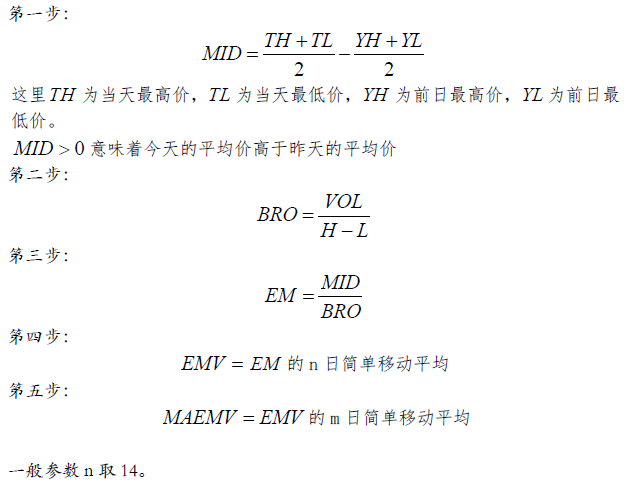

In [58]:
import pandas_ta as ta
import numpy as np
import pandas as pd

In [59]:
pd.DataFrame().ta.indicators()

Pandas TA - Technical Analysis Indicators - v0.3.14b0
Total Indicators & Utilities: 205
Abbreviations:
    aberration, above, above_value, accbands, ad, adosc, adx, alma, amat, ao, aobv, apo, aroon, atr, bbands, below, below_value, bias, bop, brar, cci, cdl_pattern, cdl_z, cfo, cg, chop, cksp, cmf, cmo, coppock, cross, cross_value, cti, decay, decreasing, dema, dm, donchian, dpo, ebsw, efi, ema, entropy, eom, er, eri, fisher, fwma, ha, hilo, hl2, hlc3, hma, hwc, hwma, ichimoku, increasing, inertia, jma, kama, kc, kdj, kst, kurtosis, kvo, linreg, log_return, long_run, macd, mad, massi, mcgd, median, mfi, midpoint, midprice, mom, natr, nvi, obv, ohlc4, pdist, percent_return, pgo, ppo, psar, psl, pvi, pvo, pvol, pvr, pvt, pwma, qqe, qstick, quantile, rma, roc, rsi, rsx, rvgi, rvi, short_run, sinwma, skew, slope, sma, smi, squeeze, squeeze_pro, ssf, stc, stdev, stoch, stochrsi, supertrend, swma, t3, td_seq, tema, thermo, tos_stdevall, trima, trix, true_range, tsi, tsignals, ttm_trend, ui, 

In [60]:
def calc_EMV(mkt_data, n=14, m=5):
    close = mkt_data['close']
    high = mkt_data['high']
    low = mkt_data['low']
    vol = mkt_data['vol']
    """ 指标计算 """
    MID = ((high+low)-(high+low).shift(1))/2
    BRO = vol/(high-low)
    EM = MID/BRO
    EMV = EM.rolling(n).mean()
    MAEMV = EMV.rolling(m).mean()
    """ 赋值 """
    mkt_data['MID'] = MID
    mkt_data['BRO'] = BRO
    mkt_data['EM'] = EM
    mkt_data['EMV'] = EMV
    mkt_data['MAEMV'] = MAEMV
    return mkt_data

# 计算信号
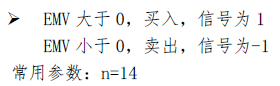

In [61]:
def calc_signal(mkt_data):
    EMV = mkt_data['EMV'] 
    """ 计算信号 """
    signals = []
    for emv, pre_emv in zip(EMV, EMV.shift(1)):
        signal = None
        if emv>0:
            signal = 1
        elif emv<0:
            signal = -1
        signals.append(signal)
    """ 赋值 """
    mkt_data['signal'] = signals
    return mkt_data

# 计算持仓

In [62]:
def calc_position(mkt_data):
    mkt_data['position'] = mkt_data['signal'].fillna(method='ffill').shift(1).fillna(0)
    return mkt_data

# 计算结果

In [63]:
def statistic_performance(mkt_data, r0=0.03, data_period=1440):
    position = mkt_data['position']
    
    """      序列型特征 
        hold_r :      持仓收益
        hold_win :    持仓胜负
        hold_cumu_r : 累计持仓收益
        drawdown :    回撤
        ex_hold_r :   超额收益
    """
    hold_r = mkt_data['pct_chg']/100 * position
    hold_win = hold_r>0
    hold_cumu_r = (1+hold_r).cumprod() - 1
    drawdown = (hold_cumu_r.cummax()-hold_cumu_r)/(1+hold_cumu_r).cummax()    
    ex_hold_r= hold_r-r0/(250*1440/data_period)

    mkt_data['hold_r'] = hold_r
    mkt_data['hold_win'] = hold_win
    mkt_data['hold_cumu_r'] = hold_cumu_r
    mkt_data['drawdown'] = drawdown
    mkt_data['ex_hold_r'] = ex_hold_r
    
    """       数值型特征 
        v_hold_cumu_r：         累计持仓收益
        v_pos_hold_times：      多仓开仓次数
        v_pos_hold_win_times：  多仓开仓盈利次数
        v_pos_hold_period：     多仓持有周期数
        v_pos_hold_win_period： 多仓持有盈利周期数
        v_neg_hold_times：      空仓开仓次数
        v_neg_hold_win_times：  空仓开仓盈利次数
        v_neg_hold_period：     空仓持有盈利周期数
        v_neg_hold_win_period： 空仓开仓次数
        v_hold_period：         持仓周期数（最后一笔未平仓订单也算）
        v_hold_win_period：     持仓盈利周期数（最后一笔未平仓订单也算）
        v_max_dd：              最大回撤
        v_annual_std：          年化标准差
        v_annual_ret：          年化收益
        v_sharpe：              夏普率
    """
    v_hold_cumu_r = hold_cumu_r.tolist()[-1]

    v_pos_hold_times= 0 
    v_pos_hold_win_times = 0
    v_pos_hold_period = 0
    v_pos_hold_win_period = 0
    v_neg_hold_times= 0 
    v_neg_hold_win_times = 0
    v_neg_hold_period = 0
    v_neg_hold_win_period = 0
    for w, r, pre_pos, pos in zip(hold_win, hold_r, position.shift(1), position):
        # 有换仓（先结算上一次持仓，再初始化本次持仓）
        if pre_pos!=pos: 
            # 判断pre_pos非空：若为空则是循环的第一次，此时无需结算，直接初始化持仓即可
            if pre_pos == pre_pos:
                # 结算上一次持仓
                if pre_pos>0:
                    v_pos_hold_times += 1
                    v_pos_hold_period += tmp_hold_period
                    v_pos_hold_win_period += tmp_hold_win_period
                    if tmp_hold_r>0:
                        v_pos_hold_win_times+=1
                elif pre_pos<0:
                    v_neg_hold_times += 1      
                    v_neg_hold_period += tmp_hold_period
                    v_neg_hold_win_period += tmp_hold_win_period
                    if tmp_hold_r>0:                    
                        v_neg_hold_win_times+=1
            # 初始化本次持仓
            tmp_hold_r = r
            tmp_hold_period = 0
            tmp_hold_win_period = 0
        else: # 未换仓
            if abs(pos)>0:
                tmp_hold_period += 1
                if r>0:
                    tmp_hold_win_period += 1
                if abs(r)>0:
                    tmp_hold_r = (1+tmp_hold_r)*(1+r)-1       

    v_hold_period = (abs(position)>0).sum()
    v_hold_win_period = (hold_r>0).sum()
    v_max_dd = drawdown.max()    
    v_annual_ret = pow( 1+v_hold_cumu_r, 
                      1/(data_period/1440*len(mkt_data)/250) )-1
    v_annual_std = ex_hold_r.std() * np.sqrt(250*1440/data_period) 
    v_sharpe= v_annual_ret / v_annual_std

    """ 生成Performance DataFrame """
    performance_cols = ['累计收益', 
                        '多仓次数', '多仓胜率', '多仓平均持有期', 
                        '空仓次数', '空仓胜率', '空仓平均持有期', 
                        '日胜率', '最大回撤', '年化收益/最大回撤',
                        '年化收益', '年化标准差', '年化夏普'
                       ]
    performance_values = ['{:.2%}'.format(v_hold_cumu_r),
                          v_pos_hold_times, '{:.2%}'.format(v_pos_hold_win_times/v_pos_hold_times), 
                                            '{:.2f}'.format(v_pos_hold_period/v_pos_hold_times),
                          v_neg_hold_times, '{:.2%}'.format(v_neg_hold_win_times/v_neg_hold_times), 
                                            '{:.2f}'.format(v_neg_hold_period/v_neg_hold_times),
                          '{:.2%}'.format(v_hold_win_period/v_hold_period), 
                          '{:.2%}'.format(v_max_dd), 
                          '{:.2f}'.format(v_annual_ret/v_max_dd),
                          '{:.2%}'.format(v_annual_ret), 
                          '{:.2%}'.format(v_annual_std), 
                          '{:.2f}'.format(v_sharpe)
                         ]
    performance_df = pd.DataFrame(performance_values, index=performance_cols)
    return mkt_data, performance_df

# 可视化结果

In [64]:
import datetime
from bokeh.plotting import figure, show, output_notebook
from bokeh.layouts import column, row, gridplot, layout
from bokeh.models import Span
output_notebook()

Loading BokehJS ...

In [65]:
def visualize_performance(mkt_data):
    mkt_data['trade_datetime'] = mkt_data['trade_date'].apply(lambda x: datetime.datetime.strptime(x, '%Y%m%d'))
    dt = mkt_data['trade_datetime']

    f1 = figure(height=300, width=700, 
                sizing_mode='stretch_width', 
                title='Target Trend',
                x_axis_type='datetime',
                x_axis_label="trade_datetime", y_axis_label="close")
    f2 = figure(height=200, sizing_mode='stretch_width', 
                title='Position',
                x_axis_label="trade_datetime", y_axis_label="position",
                x_axis_type='datetime',
                x_range=f1.x_range)
    f3 = figure(height=200, sizing_mode='stretch_width', 
                title='Return',
                x_axis_type='datetime',
                x_range=f1.x_range)
    f4 = figure(height=200, sizing_mode='stretch_width', 
                title='Drawdown',
                x_axis_type='datetime',
                x_range=f1.x_range)

    indi = figure(height=200, sizing_mode='stretch_width', 
                  title='KDJ',
                  x_axis_type='datetime',
                  x_range=f1.x_range
                 )

    # 绘制行情
    close = mkt_data['close']
    cumu_hold_close = (mkt_data['hold_cumu_r']+1)
    f1.line(dt, close/close.tolist()[0], line_width=1)
    f1.line(dt, cumu_hold_close, line_width=1, color='red')

    # 绘制指标
    

    # 绘制仓位
    position = mkt_data['position']
    f2.step(dt, position)

    # 绘制收益
    hold_r = mkt_data['hold_r']
    f3.vbar(x=dt, top=hold_r)

    # 绘制回撤
    drawdown = mkt_data['drawdown']
    f4.line(dt, -drawdown, line_width=1)

    #p = column(f1,f2,f3,f4)
    p = gridplot([ [f1],
                   #[indi],
                   [f2], 
                   [f3],
                   [f4]
                 ])
    show(p)

# 整体执行

In [66]:
daily_300 = calc_EMV(daily_300, n=14, m=5)
daily_300 = calc_signal(daily_300)
daily_300 = calc_position(daily_300)
daily_300

,index,ts_code,trade_date,close,open,high,low,pre_close,change,pct_chg,...,amount,MID,BRO,EM,EMV,MAEMV,signal,position,hold_r,cumu_hold_nv
0,4145,000300.SH,20050104,982.7940,994.7690,994.7690,980.6580,1000.0000,-17.2060,-1.7206,...,4.431977e+06,NaN,5.253256e+05,NaN,NaN,NaN,NaN,0.0,-0.000000,1.000000
1,4144,000300.SH,20050105,992.5640,981.5770,997.3230,979.8770,982.7940,9.7700,0.9941,...,4.529208e+06,0.88650,4.080654e+05,0.000002,NaN,NaN,NaN,0.0,0.000000,1.000000
2,4143,000300.SH,20050106,983.1740,993.3310,993.7880,980.3300,992.5640,-9.3900,-0.9460,...,3.921015e+06,-1.54100,4.672335e+05,-0.000003,NaN,NaN,NaN,0.0,-0.000000,1.000000
3,4142,000300.SH,20050107,983.9580,983.0450,995.7110,979.8120,983.1740,0.7840,0.0797,...,4.737469e+06,0.70250,4.590662e+05,0.000002,NaN,NaN,NaN,0.0,0.000000,1.000000
4,4141,000300.SH,20050110,993.8790,983.7600,993.9590,979.7890,983.9580,9.9210,1.0083,...,3.762933e+06,-0.88750,4.087296e+05,-0.000002,NaN,NaN,NaN,0.0,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4141,4,000300.SH,20220117,4767.2762,4728.7595,4775.2385,4726.7083,4726.7317,40.5445,0.8578,...,2.637882e+08,6.97590,2.375751e+06,0.000003,-0.000006,-0.000005,-1.0,-1.0,-0.008578,5.782691
4142,3,000300.SH,20220118,4813.3472,4766.7811,4826.3003,4747.9200,4767.2762,46.0710,0.9664,...,2.827494e+08,36.13675,1.924856e+06,0.000019,-0.000005,-0.000005,-1.0,-1.0,-0.009664,5.726807
4143,2,000300.SH,20220119,4780.3784,4815.8106,4828.7522,4755.9301,4813.3472,-32.9688,-0.6849,...,2.755346e+08,5.23100,1.839103e+06,0.000003,-0.000004,-0.000005,-1.0,-1.0,0.006849,5.766030
4144,1,000300.SH,20220120,4823.5091,4778.2616,4845.0048,4777.5683,4780.3784,43.1307,0.9022,...,3.043443e+08,18.94540,2.446321e+06,0.000008,-0.000003,-0.000005,-1.0,-1.0,-0.009022,5.714009


In [67]:
# 评价和展现
#result_daily_300, performance_df = statistic_performance(daily_300)
result_daily_300, performance_df = statistic_performance(daily_300[daily_300['trade_date'].apply(lambda x: x>='20050901' and x<='20120315')])
#result_daily_300, performance_df = statistic_performance(daily_300[daily_300['trade_date'].apply(lambda x: x>='20120315')])

visualize_performance(result_daily_300)
print(performance_df)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

                 0
累计收益       -17.53%
多仓次数           115
多仓胜率        39.13%
多仓平均持有期       8.91
空仓次数           114
空仓胜率        32.46%
空仓平均持有期       9.89
日胜率         49.35%
最大回撤        51.14%
年化收益/最大回撤    -0.04
年化收益        -1.99%
年化标准差       22.52%
年化夏普         -0.09


# 参数稳定性

In [68]:
def get_rolling_best_N(mkt_data, default_n=14, alternative_ns=[10,11,12,13,14,15,16], choice_period=125):
    """ 生成一个dict，存放所有参数下生成的mkt_data """
    alternative_dict = {}
    for n in alternative_ns:
        mkt_data = calc_EMV(mkt_data, n=n, m=5)
        mkt_data = calc_signal(mkt_data)
        mkt_data = calc_position(mkt_data)
        mkt_data['hold_r'] = mkt_data['position'] * mkt_data['pct_chg']/100
        mkt_data['cumu_hold_nv'] = (1+mkt_data['hold_r']).cumprod()
        alternative_dict[n] = mkt_data.copy()
        
    """ 从choice_period + default_n开始，选择前choice_period期表现最好的策略的signal """
    cumu_hold_nv_df = pd.concat([alternative_dict[n][['cumu_hold_nv']] for n in alternative_ns], 
                                axis=1)
    cumu_hold_nv_df.columns=alternative_ns
    position_df = pd.concat([alternative_dict[n][['position']] for n in alternative_ns], 
                            axis=1)
    position_df.columns=alternative_ns
    
    best_Ns = [default_n] * len(mkt_data)
    best_positions = position_df[default_n].tolist()
    for idx in range(len(mkt_data)-choice_period-1):
        """取 idx - idx+choice_period 共 choice_period条数据"""
        tmp_cumu_hold_nv_df = cumu_hold_nv_df[idx:idx+choice_period]
        """比较不同n下的 hold_cumu_r/max_dd 的值"""
        tmp_comp_res = pd.DataFrame([[tmp_cumu_hold_nv_df[n].values[-1]/tmp_cumu_hold_nv_df[n].values[0]-1 for n in alternative_ns],
                                     [(1-tmp_cumu_hold_nv_df[n]/tmp_cumu_hold_nv_df[n].cummax()).max() for n in alternative_ns]
                                    ],
                                     columns=alternative_ns, 
                                     index=['hold_cumu_r', 'max_dd']).T
        tmp_comp_res['value'] = tmp_comp_res['hold_cumu_r']/tmp_comp_res['max_dd']
        """选取hold_cumu_r/max_dd最大的参数作为当期best_N，并将其下期的position作为下期的best_pos"""
        best_N = tmp_comp_res.sort_values(by='value', ascending=False).index[0]
        best_pos = position_df[best_N][idx+choice_period]
        best_Ns[idx+choice_period-1] = best_N
        best_positions[idx+choice_period] = best_pos
    best_Ns = pd.Series(best_Ns, index=mkt_data['trade_date']) 
    best_positions = pd.Series(best_positions, index=mkt_data['trade_date']) 
    return best_Ns, best_positions

In [69]:
default_n=14
alternative_ns=[10,11,12,13,14,15,16]
choice_period=250

best_Ns, best_positions = get_rolling_best_N( daily_300, 
                                             default_n=default_n, 
                                             alternative_ns=alternative_ns, 
                                             choice_period=choice_period)
print(best_Ns[choice_period:].value_counts())
daily_300['position'] = best_positions.values

10    1060
15     827
12     825
14     511
16     238
11     232
13     203
dtype: int64


In [70]:
# 评价和展现
#result_daily_300, performance_df = statistic_performance(daily_300)
#result_daily_300, performance_df = statistic_performance(daily_300[daily_300['trade_date'].apply(lambda x: x>='20050901' and x<='20120315')])
result_daily_300, performance_df = statistic_performance(daily_300[daily_300['trade_date'].apply(lambda x: x>='20120315')])

visualize_performance(result_daily_300)
print(performance_df)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

                0
累计收益       22.40%
多仓次数          137
多仓胜率       43.80%
多仓平均持有期      7.46
空仓次数          137
空仓胜率       35.04%
空仓平均持有期      7.94
日胜率        50.40%
最大回撤       42.31%
年化收益/最大回撤    0.05
年化收益        2.13%
年化标准差      22.52%
年化夏普         0.09


# 策略优化

## 策略二
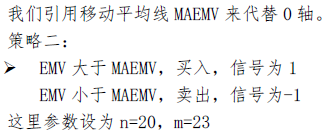

In [71]:
def calc_signal(mkt_data, m=0):
    EMV = mkt_data['EMV'] 
    MAEMV = mkt_data['MAEMV'] 
    """ 计算指标 """
    signals = []
    for emv, maemv in zip(EMV, MAEMV):
        signal = None
        if emv>maemv:
            signal = 1
        else:
            signal = -1
        signals.append(signal)
    """ 赋值 """
    mkt_data['signal'] = signals
    return mkt_data

In [72]:
daily_300 = calc_EMV(daily_300, 20, 23)
daily_300 = calc_signal(daily_300)
daily_300 = calc_position(daily_300)
daily_300

,index,ts_code,trade_date,close,open,high,low,pre_close,change,pct_chg,...,amount,MID,BRO,EM,EMV,MAEMV,signal,position,hold_r,cumu_hold_nv
0,4145,000300.SH,20050104,982.7940,994.7690,994.7690,980.6580,1000.0000,-17.2060,-1.7206,...,4.431977e+06,NaN,5.253256e+05,NaN,NaN,NaN,-1,0.0,-0.000000,1.000000
1,4144,000300.SH,20050105,992.5640,981.5770,997.3230,979.8770,982.7940,9.7700,0.9941,...,4.529208e+06,0.88650,4.080654e+05,0.000002,NaN,NaN,-1,-1.0,0.000000,1.000000
2,4143,000300.SH,20050106,983.1740,993.3310,993.7880,980.3300,992.5640,-9.3900,-0.9460,...,3.921015e+06,-1.54100,4.672335e+05,-0.000003,NaN,NaN,-1,-1.0,-0.000000,1.000000
3,4142,000300.SH,20050107,983.9580,983.0450,995.7110,979.8120,983.1740,0.7840,0.0797,...,4.737469e+06,0.70250,4.590662e+05,0.000002,NaN,NaN,-1,-1.0,0.000000,1.000000
4,4141,000300.SH,20050110,993.8790,983.7600,993.9590,979.7890,983.9580,9.9210,1.0083,...,3.762933e+06,-0.88750,4.087296e+05,-0.000002,NaN,NaN,-1,-1.0,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4141,4,000300.SH,20220117,4767.2762,4728.7595,4775.2385,4726.7083,4726.7317,40.5445,0.8578,...,2.637882e+08,6.97590,2.375751e+06,0.000003,-0.000006,-0.000001,-1,-1.0,-0.008578,5.782691
4142,3,000300.SH,20220118,4813.3472,4766.7811,4826.3003,4747.9200,4767.2762,46.0710,0.9664,...,2.827494e+08,36.13675,1.924856e+06,0.000019,-0.000003,-0.000001,-1,-1.0,-0.009664,5.726807
4143,2,000300.SH,20220119,4780.3784,4815.8106,4828.7522,4755.9301,4813.3472,-32.9688,-0.6849,...,2.755346e+08,5.23100,1.839103e+06,0.000003,-0.000003,-0.000002,-1,-1.0,0.006849,5.766030
4144,1,000300.SH,20220120,4823.5091,4778.2616,4845.0048,4777.5683,4780.3784,43.1307,0.9022,...,3.043443e+08,18.94540,2.446321e+06,0.000008,-0.000003,-0.000002,-1,-1.0,-0.009022,5.714009


In [73]:
# 评价和展现
#result_daily_300, performance_df = statistic_performance(daily_300)
#result_daily_300, performance_df = statistic_performance(daily_300[daily_300['trade_date'].apply(lambda x: x>='20050901' and x<='20120315')])
result_daily_300, performance_df = statistic_performance(daily_300[daily_300['trade_date'].apply(lambda x: x>='20120315')])

visualize_performance(result_daily_300)
print(performance_df)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

                 0
累计收益       136.83%
多仓次数            99
多仓胜率        40.40%
多仓平均持有期      11.17
空仓次数            99
空仓胜率        40.40%
空仓平均持有期      10.90
日胜率         50.56%
最大回撤        27.27%
年化收益/最大回撤     0.34
年化收益         9.40%
年化标准差       22.51%
年化夏普          0.42
